#**2 Monte Carlo Tree Search (MCTS)**

**Construct a binary tree** Construct a binary tree of depth d = 20 (or more – if you’re feeling lucky). Since the tree is binary, there are two branches (aka. edges, directions, decisions, etc) emanating from each node, each branch (call them L(eft) and R(ight)) pointing to a unique child node (except, of course, for the leaf nodes – see Fig 1). We can therefore assign to each node a
unique “address” (A) that captures the route down the tree to reach that node (e.g. A = LLRL – for an example, again see Fig 1). Finally, pick a random leaf-node as your target node and let’s denote its address as $A_{t}.$

**Assign values to leaf-nodes** -Next, assign to each of the $2^d$ leaf-nodes a value as follows:

• For every leaf-node i compute the edit-distance between its address $A_{i}$ and the address
$A_{t}$ of the target leaf, i.e. $d_{i}:= d(A_{i}, A_{t}).$

• Recall that the edit-distance counts the number of positions at which two strings differ,
e.g.: d(LRLR, LRRR) = 1, d(LRRL, LLLL) = 2, d(RRLL, RLRR) = 3

• Finally, define the value $x_{i}$ of leaf-node i to be a decreasing function of the distance 
$d_{i} = d(A_{i},A_{t})$ to the target node, and sprinkle a bit of noise for good measure: 
e.g. $x_{i}=B e^{-d_{i} / \tau} + ε_{i}$

where B and τ are chosen such that most nodes have a non-negligible value (e.g. B = 10 and $τ = d_{max}/5$ and $ε_{i} ∼ N(0, 1)$).

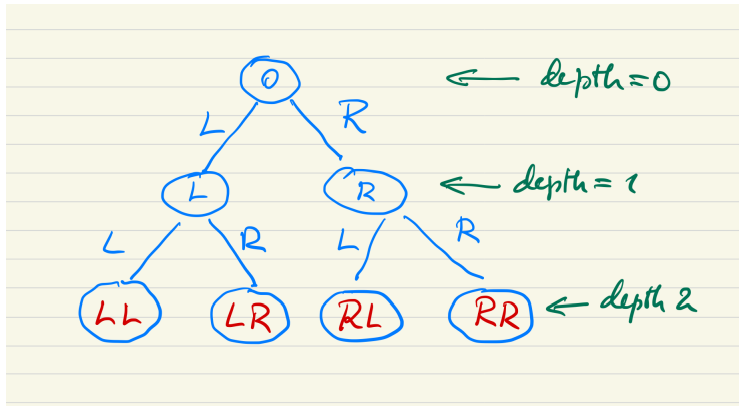

In [8]:
class Node(object):
    def __init__(self, direction="", parent=None, left_child=None, right_child=None):
        """
        Initializes a node.
        :param direction: Direction that leads to the node. Can be "L" or "R".
        :param parent: Pointer to the parent node.
        :param left_child: Pointer to the left child node.
        :param right_child: Pointer to the right child node.
        """
        self.direction = direction
        self.parent = parent
        self.left_child = left_child
        self.right_child = right_child
        self.address = self.get_address()
        self.value = 0


    def get_address(self):
        """
        Returns the address of the node.
        :return: String denoting the address of the node.
        """
        if self.is_root():
            return "0"
        else:
            return self.parent.address[1:] + self.direction if self.parent.is_root() else self.parent.address + self.direction

    def is_terminal(self):
        """
        Returns whether the node is a leaf node.
        :return: Boolean denoting whether the node is a leaf node.
        """
        return self.left_child is None and self.right_child is None

    def is_root(self):
        """
        Returns whether the node is a root node.
        :return: Boolean denoting whether the node is a root node.
        """
        return self.parent is None

    def __gt__(self, other):
        """
        Returns whether the node is greater than the other node.
        :param other: Other node.
        :return: Boolean denoting whether the node is greater than the other node.
        """
        return self.value > other.value

    def __lt__(self, other):
        """
        Returns whether the node is less than the other node.
        :param other: Other node.
        :return: Boolean denoting whether the node is less than the other node.
        """
        return self.value < other.value

    def __str__(self):
        return f"{self.address}"

    def __repr__(self):
        return f"{self.address} ({self.value:.1f})"

In [15]:
import numpy as np

np.random.seed(0)

# constants
LEFT = "L"
RIGHT = "R"


class BinaryTree(object):
    def __init__(self, depth, b, tau, eps):
        """
        Initializes a new tree.
        :param depth: Integer denoting the depth of the tree.
        :param b: Integer denoting the parameter B for the value x_i.
        :param tau: Integer denoting the parameter tau for the value x_i.
        """
        self.depth = depth
        self.root = self.build_tree(Node(), depth)
        self.leaves = self.get_leaves()
        self.target = self.get_random_target()
        self.compute_leaves_values(b, tau, eps)

    def build_tree(self, node, depth):
        """
        Builds the tree.
        :param node: Node object to expand.
        :param depth: Integer denoting the remaining depth of the tree to expand.
        :return: Node object denoting the root of the tree.
        """
        if depth == 0:
            return node
        else:
            node.left_child = self.build_tree(Node(direction=LEFT, parent=node), depth - 1)
            node.right_child = self.build_tree(Node(direction=RIGHT, parent=node), depth - 1)
            return node

    def get_leaves(self):
        """
        Returns a list of all leaves in the tree.
        :return: List of all leaves in the tree.
        """
        leaves = []
        nodes = [self.root]
        for d in range(self.depth+1):
            for node in nodes:
                if node.is_terminal():
                    leaves.append(node)
            if d < self.depth:
                new_nodes = []
                for node in nodes:
                    new_nodes.append(node.left_child)
                    new_nodes.append(node.right_child)
                nodes = new_nodes
        return leaves

    def get_random_target(self):
        """
        Returns a random target from the tree leaves.
        :return: Node object denoting the random target.
        """
        return np.random.choice(self.leaves)

    def compute_distance(self, address):
        """
        Computes the edit-distance to the target.
        :param address: String denoting the address of the node.
        :return: Integer denoting the edit-distance to the target.
        """
        return sum(1 for a, b in zip(address, self.target.address) if a != b)

    def compute_leaves_values(self, b, tau, eps):
        """
        Computes the values of the leaves based on the distance from the target leaf.
        :param b: Integer denoting the parameter B for the x_i.
        :param tau: Integer denoting the parameter tau for the x_i.
        """
        for leaf in self.leaves:
            leaf.value = b * np.exp(-self.compute_distance(leaf.address)/tau)+eps

    def update_root(self, direction):
        """
        Updates the root of the tree.
        :param address: String denoting the direction to choose for the new root.
        """
        # decrease the depth of the tree
        self.depth = self.depth - 1
        # update the root
        if direction == LEFT:
            self.root = self.root.left_child
        elif direction == RIGHT:
            self.root = self.root.right_child
        else:
            raise ValueError("Direction must be either R or L.")

    def __repr__(self):
        """
        Returns a string representation of the tree.
        :return: String representation of the tree.
        """
        tree_string = ""
        nodes = [self.root]
        for d in range(self.depth+1):
            tree_string += f"Depth {d}: {nodes}\n"

            if d < self.depth:
                new_nodes = []
                for node in nodes:
                    new_nodes.append(node.left_child)
                    new_nodes.append(node.right_child)
                nodes = new_nodes
        return tree_string

In [16]:
class NodeMCTS:
    """
    Node class for MCTS
    """
    def __init__(self, state, parent=None):
        """
        Initialize the MCTS node.
        :param state: Node instance from the BinaryTree
        :param parent: Pointer to the parent NodeMCTS
        """
        self.state = state
        self.parent = parent
        self.children = []
        self.total_value = 0
        self.visits = 0

    def get_avg_value(self):
        """"
        This function return the ratio between total score and visits
        :return: a float value
        """
        if self.visits == 0:
            return 0
        else:
            return self.total_value / self.visits

    def is_leaf(self):
        """
        This function checks if the node is a leaf node in the snowcap of MCTS tree
        :return: boolean indicating if the node is a leaf node
        """
        return len(self.children) == 0

    def __repr__(self):
        """
        This function returns a string representation of the MCTS node
        :return: a string
        """
        return f"{self.state.address} ({self.total_value}/{self.visits})"


class MCTS(object):
    """
    MCTS class
    """
    def __init__(self, c=2, max_iterations=50):
        """
        Initialize the MCTS.
        :param c: value indicating the exploration factor
        :param max_iterations: maximum number of MCTS iterations
        """
        self.c = c
        self.max_iterations = max_iterations

    def select(self, node, c):
        """
        This function selects the node to expand
        :param node: a NodeMCTS object from which start the selection
        :param c: value indicating the exploration factor
        :return: a NodeMCTS object selected
        """
        # if the node is a leaf node, return the node
        if node.is_leaf():
            return node
        # otherwise, select the child with the highest UCB
        else:
            best = None
            best_ucb = -np.inf
            for child in node.children:
                if child.visits == 0:
                    ucb = np.inf
                else:
                    ucb = child.total_value / child.visits + c * np.sqrt(np.log(node.visits) / child.visits)
                if ucb > best_ucb:
                    best_ucb = ucb
                    best = child
            return self.select(best, c)

    def expand(self, node):
        """
        This function expands the node creating the children and returning a random child
        :param node: a NodeMCTS object to expand
        :return: NodeMCTS object corresponding to a random child of the father node
        """
        # create the children
        left_child = NodeMCTS(state=node.state.left_child, parent=node)
        right_child = NodeMCTS(state=node.state.right_child, parent=node)
        node.children.append(left_child)
        node.children.append(right_child)

        # select a random child
        return np.random.choice(node.children)

    def rollout(self, node):
        """
        This function simulates a random rollout from the node
        :param node: a NodeMCTS object from which start the rollout
        :return: the value of the terminal node
        """
        state = node.state
        while not state.is_terminal():
            # choose randomly a child
            state = np.random.choice([state.left_child, state.right_child])
        return state.value

    def backpropagate(self, node, value):
        """
        This function backpropagates the result of the game
        :param node: a NodeMCTS object
        :param value: value of the terminal node
        :return: None
        """
        while node is not None:
            node.visits += 1
            node.total_value += value
            node = node.parent

    def best_direction(self, node):
        """
        This function returns the best direction for the node and the values for each direction
        :param node: a NodeMCTS object
        :return: a pair where the first element is the best direction and the second element is the list of values for each direction
        """
        values = [child.get_avg_value() for child in node.children]
        i_best_value = np.argmax(values)
        best_direction = node.children[i_best_value].state.direction
        return best_direction, values

    def search(self, tree, dynamic_c = False, verbose=False):
        """
        This function implements the Monte Carlo Tree Search algorithm
        :param tree: tree instance of BinaryTree from which start the search
        :param dynamic_c: boolean indicating if the c parameter should be dynamically updated or fixed to 2
        :param verbose: boolean indicating if the search is verbose
        :return: the best direction to take from the root node
        """

        if verbose:
            print(f"🔍 MCTS execution from node {tree.root}")

        # initialize the root node
        root = NodeMCTS(state=tree.root)

        # run the iterations
        for i in range(self.max_iterations):
            # select the node to expand
            c = (2 + (1 - i / self.max_iterations) * 6) if dynamic_c else 2
            node = self.select(root, c)

            # expand only when if the node is the root or when it is a leaf node already visited
            if node == root or (node.is_leaf() and node.visits > 0 and not node.state.is_terminal()):
                node = self.expand(node)

            # perform a rollout
            value = self.rollout(node)

            # backpropagate the result
            self.backpropagate(node, value)

        # choose the best direction
        best_direction, values = self.best_direction(root)

        if verbose:
            direction_icon = "⏪" if best_direction == LEFT else "➡️"
            print("\tAverage values of the children:", [round(v,2) for v in values])
            print(f"\tBest direction: {best_direction} {direction_icon}")

        # return the best direction from the root node
        return best_direction

In [24]:
def main():
    # create the tree
    print("🌲 Building the tree...")
    tree = BinaryTree(depth=20, b=20, tau=4, eps=0.05)
    best_leaf = max(tree.leaves)
    print(f"The address of the highest value leaf is {best_leaf.__repr__()}")

    # create the MCTS
    c = 8
    dynamic_c = False
    print(f"\nStarting the MCTS with dynamic c...") if dynamic_c else print(f"\nStarting the MCTS with c={c}...")
    mcts = MCTS(max_iterations=50, c=c)

    optimal_path = ""
    while not tree.root.is_terminal():
        # search the best direction
        direction = mcts.search(tree, dynamic_c=dynamic_c, verbose=True)
        optimal_path += direction

        # update the tree
        tree.update_root(direction)

    print(f"Optimal path obtained from the search: {optimal_path}")
    if optimal_path == best_leaf.address:
        print(f"✅ It is the address expected!")
    else:
        print(f"❌ It is NOT the address expected!")


if __name__ == "__main__":
    main()

🌲 Building the tree...
The address of the highest value leaf is RRLLLRLLLLLRLLLRRRRL (20.1)

Starting the MCTS with c=8...
🔍 MCTS execution from node 0
	Average values of the children: [1.47, 2.28]
	Best direction: R ➡️
🔍 MCTS execution from node R
	Average values of the children: [1.76, 3.3]
	Best direction: R ➡️
🔍 MCTS execution from node RR
	Average values of the children: [1.95, 3.13]
	Best direction: R ➡️
🔍 MCTS execution from node RRR
	Average values of the children: [2.52, 2.38]
	Best direction: L ⏪
🔍 MCTS execution from node RRRL
	Average values of the children: [3.36, 1.93]
	Best direction: L ⏪
🔍 MCTS execution from node RRRLL
	Average values of the children: [2.84, 4.11]
	Best direction: R ➡️
🔍 MCTS execution from node RRRLLR
	Average values of the children: [4.99, 1.51]
	Best direction: L ⏪
🔍 MCTS execution from node RRRLLRL
	Average values of the children: [2.01, 3.66]
	Best direction: R ➡️
🔍 MCTS execution from node RRRLLRLR
	Average values of the children: [6.62, 2.99]
	B


Execute MCTS with c=8: 100%|██████████| 18/18 [06:41<00:00, 22.31s/ experiment]

Execute MCTS with dynamic c: 100%|██████████| 18/18 [06:49<00:00, 22.77s/ experiment]


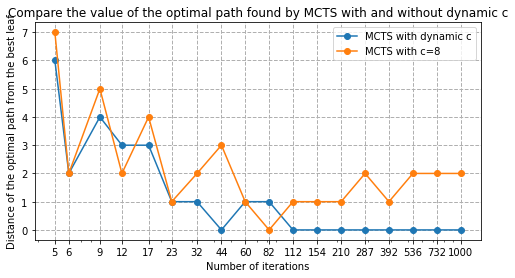

In [26]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(15)


def run_experiment(max_iterations, dynamic_c=False):
    """
    Run a single experiment of a sequence of MCTS searches to find the optimal path.
    :param max_iterations: Number of iterations to run the MCTS.
    :param dynamic_c: Boolean indicating whether to use a dynamic c or not.
    :return: value of the optimal path found from the search
    """
    tree = BinaryTree(depth=20, b=20, tau=4, eps = 0.05)
    best_leaf = max(tree.leaves)
    mcts = MCTS(max_iterations=max_iterations, c=8)

    optimal_path = ""
    while tree.depth > 0:
        # search the best direction
        direction = mcts.search(tree, dynamic_c=dynamic_c, verbose=False)
        optimal_path += direction

        # update the tree
        tree.update_root(direction)

    # return the distance of the optimal path found from the search wrt the best leaf
    return sum(1 for a, b in zip(optimal_path, best_leaf.address) if a != b)


def main():
    # compute statistics for static c and dynamic c
    n_iterations = np.logspace(0.7, 3, num=18, base=10, dtype=int)
    values_static_c = [run_experiment(max_iterations=n, dynamic_c=False) for n in tqdm(n_iterations, desc='Execute MCTS with c=8', unit=' experiment')]
    values_dynamic_c = [run_experiment(max_iterations=n, dynamic_c=True) for n in tqdm(n_iterations, desc='Execute MCTS with dynamic c', unit=' experiment')]

    # plot the results
    plt.figure(figsize=(8, 4))
    plt.plot(n_iterations, values_dynamic_c, '-o', label="MCTS with dynamic c")
    plt.plot(n_iterations, values_static_c, '-o', label="MCTS with c=8")
    plt.xlabel("Number of iterations")
    plt.ylabel("Distance of the optimal path from the best leaf")
    plt.title("Compare the value of the optimal path found by MCTS with and without dynamic c")
    plt.grid(linestyle='--', linewidth=1)
    plt.xscale("log")
    plt.xticks(n_iterations, n_iterations)
    plt.legend()
    plt.show()


if __name__ == "__main__":
    main()